In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import pandas as pd
import statistics
import datetime
from tqdm import tqdm
from matplotlib.pyplot import cm


import seaborn as sns
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
class Pandemic_Network():
    
    def __init__(self, network_type: str, nodes: int, pandemicprob: float ,sicknode = 0, SW_connections = 3, SW_randomness = 0.5, SF_k = 1, plots = False, TTR = 15):
        '''
        sicknodes - number of sick nodes to begin with
        '''

        if network_type == 'Ring': # default is a ring network
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = 0, seed=None)
        elif network_type == 'Small World':
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = SW_randomness, seed=None)
        elif network_type == 'Scale Free':
            self.g = nx.barabasi_albert_graph(n = nodes, m = SF_k, seed=None, initial_graph=None) # m = Number of edges to attach from a new node to existing nodes
        else:
            self.g = nx.erdos_renyi_graph(n = nodes, p = 0.5, seed=None, directed=False) # if network type not specified, then generate random graph (erdos renyi model)

        # self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = SW_randomness, seed=None)
        self.pos = nx.circular_layout(self.g)
        self.n = nodes
        self.t = 0
        self.p = pandemicprob
        self.want_plots = plots
        self.sicknodes = [random.randint(0, nodes-1) for i in range(sicknode)] # randomly generate n number of sicknnodes
        # if not sicknode:
        #     self.sicknodes = set([])
        # else:
        #     self.sicknodes = set([sicknode])
        self.recovered = []
        self.TTR = TTR # days to recover, default is 15, customisable dependent on model

        # initialise TTR
        initial_TTR_vals = [0 if i not in self.sicknodes else TTR + 1 for i in range(nodes)]
        initial_TTR_dict = {i:initial_TTR_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_TTR_dict, name = 'TTR')
    
    def plot(self):
        node_colors = ["firebrick" if node in self.sicknodes else "green" if node in self.recovered else "skyblue" for node in self.g.nodes()]
        nx.draw_networkx(self.g, pos = self.pos, with_labels=False, node_size=2000/self.n, node_color=node_colors, edge_color="gray", linewidths=0.5)
        plt.title("Small Worlds Graph: Nodes = "+ str(self.n)+ ", Time = " + str(self.t))
        plt.show()
        return
    
    #def sicknode
    def propagate(self, steps: int):
        #Plot initial network
        # self.plot()
        timestamps = []
        infectious_count = []
        recovery_count = []
        uninfected_count = []
        cumulative_case_count = []

        for time in tqdm(range(steps)):
            #check sick nodes
            timestamps.append(time)
            # print('Time = ', time)
            # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
            # print('Infectious:', self.sicknodes)
            # print('Recovered:', self.recovered)
            if time == 0:
                cumulative_case_count.append(len(self.sicknodes))
            else: 
                new_case = len(self.sicknodes) - infectious_count[-1]
                if  new_case > 0:
                    cumulative_case_count.append(cumulative_case_count[-1] + new_case)
                else:
                    cumulative_case_count.append(cumulative_case_count[-1]) 
                    
            infectious_count.append(len(self.sicknodes))
            recovery_count.append(len(self.recovered))
            uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))
            

            currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones
            #print("sicknodes:", currentsick)

            for i in range(len(list(self.g.nodes))):
                if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                    self.sicknodes.remove(i)
                    self.recovered.append(i)
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value
                elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                    pass
                else: # mid infectious period
                    nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value
            
            # print('Node', i, 'TTR = ',G.nodes[i]['TTR'])
            for node in currentsick:
                #print("sicknode:",node)
                neighbours = list(self.g.neighbors(node))
                #try to propagate sickness
                for neighbour in neighbours:
                    if neighbour in self.sicknodes or neighbour in self.recovered:
                        pass
                    elif np.random.random() < self.p:
                        self.sicknodes.append(neighbour)
                        nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node
                    else:
                        pass
                       
            self.t += 1 #timestep increase by 1
            
            if self.want_plots: 
                self.plot()
                
            #if len(self.sicknodes) == 0:
            #    return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count
        # self.plot()             
        return timestamps, infectious_count, recovery_count, uninfected_count, cumulative_case_count
    

100%|██████████| 400/400 [02:17<00:00,  2.92it/s]


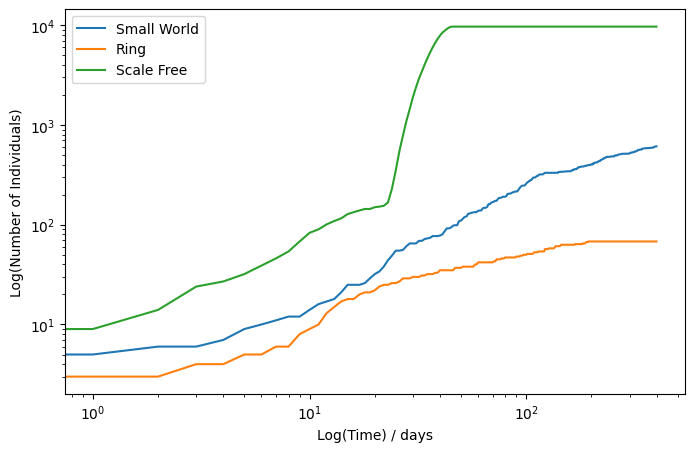

In [4]:
num_nodes = 37000
prob_inf = 0.2
sicknodes = 3
avg_connection = 3
randomness = 0.5
TTR_val = 15
# type = 'Small World'

types = ['Small World', 'Ring', 'Scale Free']

data = []

plt.figure(figsize = (8,5))

for i in types:
    G_data = Pandemic_Network(nodes = num_nodes, network_type = i, pandemicprob = prob_inf, sicknode = sicknodes, SW_connections = avg_connection, SW_randomness = randomness, plots = False, TTR = TTR_val).propagate(400)

    # plt.plot(G_data_0[0], 100*np.array(G_data_0[1])/num_nodes, label = 'Infected')
    # plt.plot(G_data_0[0], 100*np.array(G_data_0[2])/num_nodes, label = 'Recovered')
    # plt.plot(G_data_0[0], 100*np.array(G_data_0[3])/num_nodes, label = 'Uninfected')
    plt.plot(G_data[0], G_data[4], label = i)
    data.append(G_data[4])

    # plt.plot(G_data_0[0], np.array(G_data_0[4]), label = 'Cumulative')
plt.xlabel('Log(Time) / days')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Log(Number of Individuals)')
plt.legend()
# plt.title('Number of nodes = {}, Probability of infection = {}, \n Average number of connections = {}, TTR = {}'.format(num_nodes, prob_inf, avg_connection, TTR_val), fontsize = 10)
plt.show()


In [18]:
date = datetime.date.today()
country = 'Monaco'
df = pd.DataFrame(data).transpose()

df.to_csv("Simulation Data for {} {}.csv".format(country,date), index=False, header = ['Small World','Ring','Scale Free', 'Time'])

100%|██████████| 400/400 [05:43<00:00,  1.16it/s] 


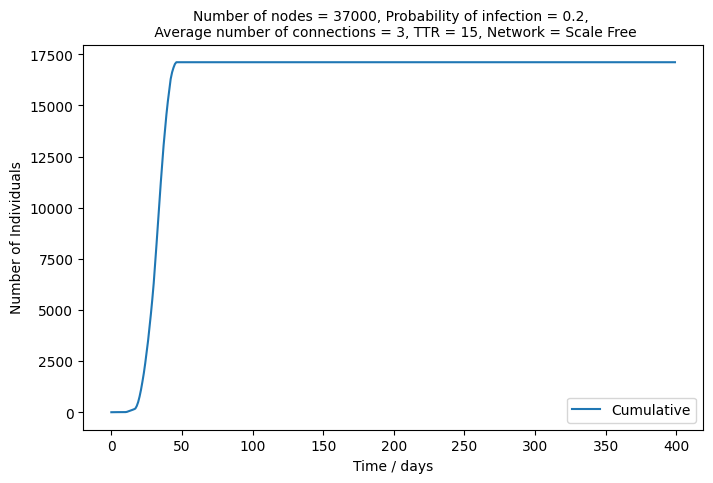

In [6]:
num_nodes = 37000
prob_inf = 0.2
sicknodes = 2
avg_connection = 3
randomness = 0.7
TTR_val = 15

# types = ['Small World', 'Scale Free', 'Ring']

G_data_0 = Pandemic_Network(nodes = num_nodes, network_type = 'Scale Free', pandemicprob = prob_inf, sicknode = sicknodes, SW_connections = avg_connection, SW_randomness = randomness, SF_k = 1, plots = False, TTR = TTR_val).propagate(400)

plt.figure(figsize = (8,5))
# plt.plot(G_data_0[0], 100*np.array(G_data_0[1])/num_nodes, label = 'Infected')
# plt.plot(G_data_0[0], 100*np.array(G_data_0[2])/num_nodes, label = 'Recovered')
# plt.plot(G_data_0[0], 100*np.array(G_data_0[3])/num_nodes, label = 'Uninfected')
plt.plot(G_data_0[0], G_data_0[4], label = 'Cumulative')

# plt.plot(G_data_0[0], np.array(G_data_0[4]), label = 'Cumulative')
plt.xlabel('Time / days')
plt.ylabel('Number of Individuals')
plt.legend()
plt.title('Number of nodes = {}, Probability of infection = {}, \n Average number of connections = {}, TTR = {}, Network = {}'.format(num_nodes, prob_inf, avg_connection, TTR_val, type), fontsize = 10)
plt.show()

In [ ]:
prob_inf = [0.05, 0.75]
fig, ax = plt.subplots(nrows = 1, ncols = 3, sharey = True, sharex = True, figsize = (15,7))
ind = 1
newdata = []
for j in prob_inf:
    # timestamps = []
    data_inf = []
    data_rec = []
    data_tot = []
    data_cum = []

    num_nodes = 30000
    #prob_inf = 0.5
    sicknodes = 1
    c = 4
    #randomness = j # Small World when randomness = 0.5
    TTR_val = 10

    repeats = 5

    for i in range(repeats):
        print(j,i)
        G_data = Pandemic_Network(nodes = num_nodes, network_type = 'Small World',pandemicprob = j, sicknode = sicknodes, SW_connections = c, SW_randomness = 0.5, plots = False, TTR = TTR_val).propagate(150)
        # timestamps.append(G_data[0])
        data_inf.append(G_data[1])
        data_rec.append(G_data[2])
        data_tot.append(G_data[3])
        data_cum.append(G_data[4])

    data_inf_std = []
    data_inf_mean = []

    data_rec_std = []
    data_rec_mean = []

    data_tot_std = []
    data_tot_mean = []

    for i in range(100):
        data_inf_std.append(statistics.stdev([data_inf[j][i] for j in range(repeats)]))
        data_inf_mean.append(statistics.mean([data_inf[j][i] for j in range(repeats)]))

        data_rec_std.append(statistics.stdev([data_rec[j][i] for j in range(repeats)]))
        data_rec_mean.append(statistics.mean([data_rec[j][i] for j in range(repeats)]))

        data_tot_std.append(statistics.stdev([data_tot[j][i] for j in range(repeats)]))
        data_tot_mean.append(statistics.mean([data_tot[j][i] for j in range(repeats)]))

    data_inf_low = np.array([data_inf_mean[i] - data_inf_std[i] for i in range(len(data_inf_std))])
    data_inf_high = np.array([data_inf_mean[i] + data_inf_std[i] for i in range(len(data_inf_std))])

    data_rec_low = np.array([data_rec_mean[i] - data_rec_std[i] for i in range(len(data_rec_std))])
    data_rec_high = np.array([data_rec_mean[i] + data_rec_std[i] for i in range(len(data_rec_std))])

    data_tot_low = np.array([data_tot_mean[i] - data_tot_std[i] for i in range(len(data_tot_std))])
    data_tot_high = np.array([data_tot_mean[i] + data_tot_std[i] for i in range(len(data_tot_std))])

    timestamps = [i for i in range(len(data_inf_mean))]


    newdata.append(np.array(data_inf_mean)/num_nodes*100)
    newdata.append(np.array(data_rec_mean)/num_nodes*100)
    newdata.append(np.array(data_tot_mean)/num_nodes*100)
    newdata.append(data_inf_low)
    newdata.append(data_inf_high)
    newdata.append(data_rec_low)
    newdata.append(data_rec_high)
    newdata.append(data_tot_low)
    newdata.append(data_tot_high)
    
    ax[0].plot(timestamps,np.array(data_inf_mean)/num_nodes*100, color = cm.hsv(ind/3), label = '$Average Edges = {}'.format(c))
    ax[1].plot(timestamps,np.array(data_rec_mean)/num_nodes*100, color = cm.hsv(ind/3), label = '$Average Edges = {}'.format(c))
    ax[2].plot(timestamps,np.array(data_tot_mean)/num_nodes*100, color = cm.hsv(ind/3), label = '$Average Edges = {}'.format(c))

    ax[0].fill_between(timestamps, data_inf_low/num_nodes*100, data_inf_high/num_nodes*100, alpha = 0.2, color = cm.hsv(ind/3), label = '$ \pm 1\sigma_{{}}$'.format(c))
    ax[1].fill_between(timestamps, data_rec_low/num_nodes*100, data_rec_high/num_nodes*100, alpha = 0.2, color = cm.hsv(ind/3), label = '$ \pm 1\sigma_{{}}$'.format(c))
    ax[2].fill_between(timestamps, data_tot_low/num_nodes*100, data_tot_high/num_nodes*100, alpha = 0.2, color = cm.hsv(ind/3), label = '$ \pm 1\sigma_{{}}$'.format(c))
    ind += 1
    
fig.suptitle('Disease Propagation for Small World Network', fontsize = 15)
ax[0].set_title('Infected')
ax[1].set_title('Recovered')
ax[2].set_title('Uninfected')

ax[0].set_ylabel('Percentage of Individuals / %')
ax[0].set_xlabel('Time / days')
ax[1].set_xlabel('Time / days')
ax[2].set_xlabel('Time / days')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()

0.05 0


100%|█████████████████████████████████████████| 150/150 [01:03<00:00,  2.36it/s]


0.05 1


100%|█████████████████████████████████████████| 150/150 [01:17<00:00,  1.93it/s]


0.05 2


100%|█████████████████████████████████████████| 150/150 [01:11<00:00,  2.09it/s]


0.05 3


100%|█████████████████████████████████████████| 150/150 [00:48<00:00,  3.07it/s]


0.05 4


100%|█████████████████████████████████████████| 150/150 [00:03<00:00, 40.37it/s]


0.75 0


100%|█████████████████████████████████████████| 150/150 [05:48<00:00,  2.32s/it]


0.75 1


100%|█████████████████████████████████████████| 150/150 [05:51<00:00,  2.34s/it]


0.75 2


 11%|████▍                                     | 16/150 [02:54<51:57, 23.27s/it]

In [46]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from matplotlib import font_manager
from scipy.optimize import curve_fit
from matplotlib.pyplot import cm
import statistics

plt.style.use('seaborn-v0_8-bright')
hfont = {'fontname': 'Times'}
csfont = {'fontname':'Didot'}
font = font_manager.FontProperties(family='Times',
                                   style='normal', size=10)


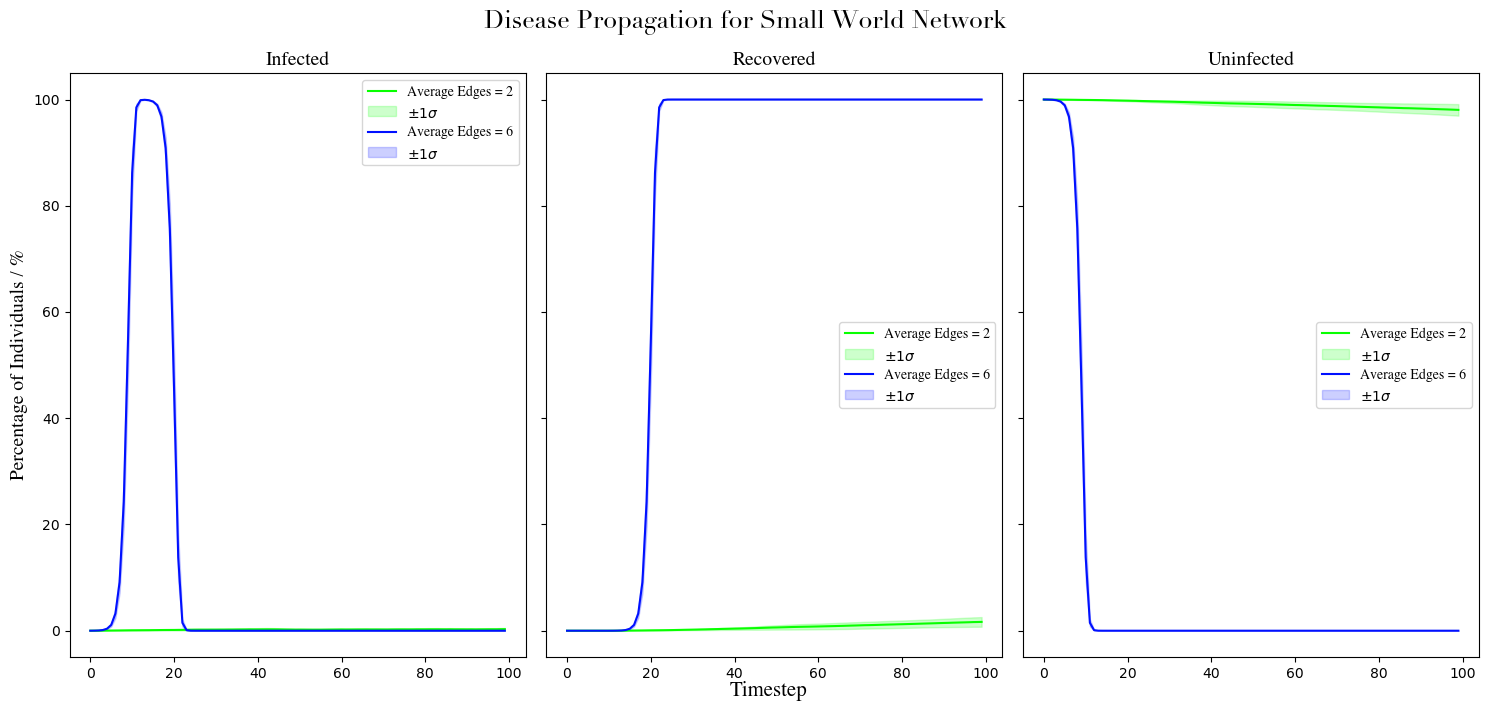

In [54]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, sharey = True, sharex = True, figsize = (15,7))

for i in range(2):
    ax[0].plot(timestamps,newdata[i*9 + 0], color = cm.hsv((i+1)/3), label = 'Average Edges = {}'.format(2+4*i))
    ax[1].plot(timestamps,newdata[i*9 + 1], color = cm.hsv((i+1)/3), label = 'Average Edges = {}'.format(2+4*i))
    ax[2].plot(timestamps,newdata[i*9 + 2], color = cm.hsv((i+1)/3), label = 'Average Edges = {}'.format(2+4*i))

    ax[0].fill_between(timestamps, newdata[i*9 + 3]/num_nodes*100, newdata[i*9 + 4]/num_nodes*100, alpha = 0.2, color = cm.hsv((i+1)/3), label = '$ \pm 1\sigma_{{}}$'.format(c))
    ax[1].fill_between(timestamps, newdata[i*9 + 5]/num_nodes*100, newdata[i*9 + 6]/num_nodes*100, alpha = 0.2, color = cm.hsv((i+1)/3), label = '$ \pm 1\sigma_{{}}$'.format(c))
    ax[2].fill_between(timestamps, newdata[i*9 + 7]/num_nodes*100, newdata[i*9 + 8]/num_nodes*100, alpha = 0.2, color = cm.hsv((i+1)/3), label = '$ \pm 1\sigma_{{}}$'.format(c))
    ind += 1


fig.suptitle('Disease Propagation for Small World Network', fontsize = 18, **csfont)
ax[0].set_title('Infected', fontsize = 14, **hfont)
ax[1].set_title('Recovered', fontsize = 14, **hfont)
ax[2].set_title('Uninfected', fontsize = 14, **hfont)

ax[0].set_ylabel('Percentage of Individuals / %', fontsize = 14, **hfont)
fig.text(0.49, 0, "Timestep", fontsize = 15, **hfont)

ax[0].legend(prop = font)
ax[1].legend(prop = font)
ax[2].legend(prop = font)
plt.tight_layout()
plt.show()

In [ ]:
# Run to test whether this tipping point behaviour is dependent on the number of nodes

nodes = [i for i in range(10,100,10)]
connections = [2,3,4]

prob_inf = 0.8
sicknodes = 3
randomness = 0
TTR_val = 15

for i in nodes:
    for j in connections:
        print('Number for Nodes =', i, 'for avg connections =', j)
        sim = Pandemic_Network(nodes = i, pandemicprob = prob_inf, sicknode = sicknodes, SW_connections = j, SW_randomness = randomness, plots = False, TTR = TTR_val).go(50)

        plt.figure(figsize = (8,5))
        plt.plot(sim[0], 100*np.array(sim[1])/i, label = 'Infected')
        plt.plot(sim[0], 100*np.array(sim[2])/i, label = 'Recovered')
        plt.plot(sim[0], 100*np.array(sim[3])/i, label = 'Uninfected')

        plt.xlabel('Time / days')
        plt.ylabel('Percentage of individuals / %')
        plt.legend()
        plt.title('Number of nodes = {}, Probability of infection = {}, \n Average number of connections = {}, TTR = {}'.format(i, prob_inf, j, TTR_val), fontsize = 10)
        plt.show()

In [ ]:
# Export simulation data to csv

date = datetime.date.today()
country = 'Monaco'
df = pd.DataFrame(G_data_0).transpose()
df.to_csv("Simulation Data for {} {}.csv".format(country,date), index=False, header = ['Time', 'Infected', 'Recovered', 'Uninfected', 'Cumulative'])


In [ ]:
# Run simulation 20 times for TTR = 15
timestamps = []
data_inf = []
data_rec = []
data_tot = []
data_cum = []

num_nodes = 10000
prob_inf = 0.50
sicknodes = 2
avg_connection = 4
randomness = 0.5
TTR_val = 15

for i in range(20):
    print(i)
    G_data = Propagate_SW(nodes = num_nodes, pandemicprob = prob_inf, sicknode = sicknodes, SW_connections = avg_connection, SW_randomness = randomness, plots = False, TTR = TTR_val).go(300)
    timestamps.append(G_data[0])
    data_inf.append(G_data[1])
    data_rec.append(G_data[2])
    data_tot.append(G_data[3])
    data_cum.append(G_data[4])

In [ ]:
data_inf_std = []
data_inf_mean = []

data_rec_std = []
data_rec_mean = []

data_tot_std = []
data_tot_mean = []

for i in range(300):
    data_inf_std.append(statistics.stdev([data_inf[j][i] for j in range(20)]))
    data_inf_mean.append(statistics.mean([data_inf[j][i] for j in range(20)]))

    data_rec_std.append(statistics.stdev([data_rec[j][i] for j in range(20)]))
    data_rec_mean.append(statistics.mean([data_rec[j][i] for j in range(20)]))

    data_tot_std.append(statistics.stdev([data_tot[j][i] for j in range(20)]))
    data_tot_mean.append(statistics.mean([data_tot[j][i] for j in range(20)]))

data_inf_low = [data_inf_mean[i] - data_inf_std[i] for i in range(len(data_inf_std))]
data_inf_high = [data_inf_mean[i] + data_inf_std[i] for i in range(len(data_inf_std))]

data_rec_low = [data_rec_mean[i] - data_rec_std[i] for i in range(len(data_rec_std))]
data_rec_high = [data_rec_mean[i] + data_rec_std[i] for i in range(len(data_rec_std))]

data_tot_low = [data_tot_mean[i] - data_tot_std[i] for i in range(len(data_tot_std))]
data_tot_high = [data_tot_mean[i] + data_tot_std[i] for i in range(len(data_tot_std))]

fig, ax = plt.subplots(nrows = 1, ncols = 3, sharey = True, sharex = True, figsize = (15,7))

ax[0].plot(timestamps[0],data_inf_mean, color = 'red', label = '$\mu_{infected}$')
ax[1].plot(timestamps[0],data_rec_mean, color = 'purple', label = '$\mu_{recovered}$')
ax[2].plot(timestamps[0],data_tot_mean, color = 'blue', label = '$\mu_{uninfected}$')

ax[0].fill_between(timestamps[0], data_inf_low, data_inf_high, alpha = 0.2, color = 'red', label = '$ \pm 1\sigma_{infected}$')
ax[1].fill_between(timestamps[0], data_rec_low, data_rec_high, alpha = 0.2, color = 'purple', label = '$ \pm 1\sigma_{recovered}$')
ax[2].fill_between(timestamps[0], data_tot_low, data_tot_high, alpha = 0.2, color = 'blue', label = '$ \pm 1\sigma_{uninfected}$')

fig.suptitle('Analysis of TTR on propagation of disease, TTR = {}, p = {}, Average Connections = {}'.format(TTR_val, prob_inf, avg_connection))
ax[0].set_title('Infected')
ax[1].set_title('Recovered')
ax[2].set_title('Uninfected')

ax[0].set_ylabel('Number of Individuals')
ax[0].set_xlabel('Time / days')
ax[1].set_xlabel('Time / days')
ax[2].set_xlabel('Time / days')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()

In [ ]:
data_inf_max = []
data_inf_min = []
data_inf_mean = []

data_rec_max = []
data_rec_min = []
data_rec_mean = []

data_tot_max = []
data_tot_min = []
data_tot_mean = []

for i in range(300):
    data_inf_max.append(max([data_inf[j][i] for j in range(20)]))
    data_inf_min.append(min([data_inf[j][i] for j in range(20)]))
    data_inf_mean.append(statistics.mean([data_inf[j][i] for j in range(20)]))

    data_rec_max.append(max([data_rec[j][i] for j in range(20)]))
    data_rec_min.append(min([data_rec[j][i] for j in range(20)]))
    data_rec_mean.append(statistics.mean([data_rec[j][i] for j in range(20)]))

    data_tot_max.append(max([data_tot[j][i] for j in range(20)]))
    data_tot_min.append(min([data_tot[j][i] for j in range(20)]))
    data_tot_mean.append(statistics.mean([data_tot[j][i] for j in range(20)]))

fig, ax = plt.subplots(nrows = 1, ncols = 3, sharey = True, sharex = True, figsize = (15,7))

ax[0].plot(timestamps[0],data_inf_mean, color = 'red', label = '$\mu_{infected}$')
ax[1].plot(timestamps[0],data_rec_mean, color = 'purple', label = '$\mu_{recovered}$')
ax[2].plot(timestamps[0],data_tot_mean, color = 'blue', label = '$\mu_{uninfected}$')

ax[0].fill_between(timestamps[0], data_inf_min, data_inf_max, alpha = 0.2, color = 'red', label = '$N_{infected}^{max} - N_{infected}^{min}$')
ax[1].fill_between(timestamps[0], data_rec_min, data_rec_max, alpha = 0.2, color = 'purple', label = '$N_{recovered}^{max} - N_{recovered}^{min}$')
ax[2].fill_between(timestamps[0], data_tot_min, data_tot_max, alpha = 0.2, color = 'blue', label = '$N_{uninfected}^{max} - N_{uninfected}^{min}$')

fig.suptitle('Analysis of TTR on propagation of disease, TTR = {}'.format(TTR_val))
ax[0].set_title('Infected')
ax[1].set_title('Recovered')
ax[2].set_title('Uninfected')

ax[0].set_ylabel('Number of Individuals')
ax[0].set_xlabel('Time / days')
ax[1].set_xlabel('Time / days')
ax[2].set_xlabel('Time / days')

ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.tight_layout()
plt.show()